In [1]:
#Esto me sirve para el correcto funcionamiento de las funciones importadas en este notebook
%load_ext autoreload
%autoreload 2

# Sistema de recomendación basado en contenido

## Contexto

En los notebooks anteriores, logramos construir un clon bastante cercano al top 250 de mejores películas de IMDB y un sistema de recomendación basado en conocimiento que pedía al usuario algunas características sobre la película que buscaba y devolvía un top con las películas que mejor coincidían. Sin embargo, ambos se mantenían bastante primitivos: **el primero era un simple top que no tomaba en cuenta al usuario y el segundo ofrecía recomendaciones algo genéricas**.

Para profundizar más en esto y avanzar en el camino hacia un buen sistema de recomendación, podríamos considerar otras características de las películas e incluirlas. Una de estas características sería **considerar la sinopsis de la película, el director o los actores implicados**. Esto le daría más profundidad a las recomendaciones y, al ser algo que podemos analizar nosotros antes que el usuario, simplificaría mucho el proceso de entender sus gustos. Se volvería tan simple como preguntarle por los títulos de algunas películas que le gusten y, en base a eso, generar recomendaciones, **tal como lo hacen plataformas como Netflix**.

De aquí surge el título de este notebook, **el sistema de recomendación basado en contenido**, que toma una película y la compara con otras para ver si sus contenidos son similares.

## Carga de los datos

En el notebook anterior hicimos algún preprocesamiento sobre el dataframe que contaba con la metadata de la película para que este se volviera manipulable y así construir lo que queríamos, en este notebook vamos a empezar usando ese mismo dataframe para generar nuestro nuevo sistema de recomendación:

In [2]:
#Importo las librerías a usar
from utils.paths import crear_funcion_directorio
import pandas as pd

#Creo un acceso directo a la carpeta de data
data_dir = crear_funcion_directorio("data")

#Cargo el dataset
df_metadata = pd.read_csv(data_dir("processed", "movies_metadata_filtered.csv"))

Verificamos que se haya cargado correctamente:

In [3]:
df_metadata.head()

,title,genres,runtime,vote_average,vote_count,release_year
0,Toy Story,"['Animation', 'Comedy', 'Family']",81.0,7.7,5415.0,1995.0
1,Jumanji,"['Adventure', 'Fantasy', 'Family']",104.0,6.9,2413.0,1995.0
2,Grumpier Old Men,"['Romance', 'Comedy']",101.0,6.5,92.0,1995.0
3,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']",127.0,6.1,34.0,1995.0
4,Father of the Bride Part II,['Comedy'],106.0,5.7,173.0,1995.0


Este dataframe si bien tiene la estructura en la cual lo dejamos, le está faltando la información sobre la sinopsis de la película, para eso debemos cargar el dataframe original y unirlo a este:

In [4]:
orig_df_metadata = pd.read_csv(data_dir("raw", "movies_metadata.csv"), low_memory= False)

df_metadata['overview'], df_metadata['id'] = orig_df_metadata['overview'], orig_df_metadata['id']

df_metadata.head()

,title,genres,runtime,vote_average,vote_count,release_year,overview,id
0,Toy Story,"['Animation', 'Comedy', 'Family']",81.0,7.7,5415.0,1995.0,"Led by Woody, Andy's toys live happily in his ...",862
1,Jumanji,"['Adventure', 'Fantasy', 'Family']",104.0,6.9,2413.0,1995.0,When siblings Judy and Peter discover an encha...,8844
2,Grumpier Old Men,"['Romance', 'Comedy']",101.0,6.5,92.0,1995.0,A family wedding reignites the ancient feud be...,15602
3,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']",127.0,6.1,34.0,1995.0,"Cheated on, mistreated and stepped on, the wom...",31357
4,Father of the Bride Part II,['Comedy'],106.0,5.7,173.0,1995.0,Just when George Banks has recovered from his ...,11862


Podemos ver que unieron correctamente (me dí cuenta leyendo por encima la sinopsis de Toy Story), en este caso además de la sinopsis de la película **'overview'** también uní la columna **'id'** para dejar ya el dataframe listo para unirlo con otros de la misma fuente que traen más información útil.

## Comparación de textos mediante vectores

### Explicación general


El objetivo de los modelos que vamos a construir es **comparar pares de textos**, en este caso, las sinopsis de las películas. Pero antes de proceder, surge una pregunta natural: **¿Cómo cuantificamos numéricamente la similitud entre dos textos distintos?**

El primer paso para responder esta pregunta es convertir estos textos en estructuras matemáticas, y una que funciona muy bien en este caso **son los vectores**. La construcción de estos vectores se puede explicar de la siguiente manera:

1. Tenemos 𝑛 textos distintos, supongamos que cada uno es el guión de una película.
2. Realizamos el preprocesamiento adecuado para eliminar signos de puntuación, conectores y convertir todo a minúsculas.
3. Tomamos las apariciones únicas de cada palabra en todos los textos. Por ejemplo, si "auto" aparece en tres textos distintos, la consideramos una sola vez. Este conjunto de palabras únicas se llama **"vocabulario"**.
4. Luego, podemos contar la cantidad de apariciones de cada palabra disponible en el vocabulario. Esto nos proporciona una cantidad numérica, aunque varía según el tipo de vectores que usemos.
5. Finalmente, comparamos número a número un texto A con el resto de los textos disponibles, analizando de a pares. El texto con palabras que aparecen de manera similar será considerado el **"más parecido"**.

Como remarcaba en el punto 4, la forma de cuantificar puede variar según el tipo de vectores que usemos, o mejor dicho, **que vectorizador utilizemos**. De esto se desprenden 2 tipos de vectorizadores bastante usados a la hora de construir estos modelos: **"CountVectorizer" y "TF-IDF Vectorizer"**. 

### CountVectorizer

El **"CountVectorizer"** es el tipo más simple de vectorizador, y es justamente el que se explicaba entre los puntos 4 y 5 del texto anterior. Sin embargo, podemos reforzar su idea con un ejemplo:

Supongamos que tenemos 3 cadenas de texto A, B y C de la siguiente forma:

* **A:** "El cielo está rojo"
* **B:** "Los pantalones son azules"
* **C:** "La remera es color rojo"

Ahora es cuando entra en juego **"CountVectorizer"** para convertir estas 3 cadenas de texto a su forma vectorial y poder compararlas. Para eso, extraemos el "vocabulario" de los 3 textos en conjunto: 

* El, cielo, Los, pantalones, son, está, rojo, azules, La, remera, es, color

En total tenemos **12 palabras distintas**. Notemos que la palabra "rojo" apareció 2 veces entre los 3 textos, pero para esto solo debe considerarse una sola vez. Una práctica común al construir estos vectores es eliminar palabras muy comunes, que en este caso son los conectores (El, La, Los...), obteniendo un vocabulario de la siguiente forma:

* cielo, pantalones, rojo, azules, remera, color

Vemos que hemos reducido el vocabulario a **solo 6 palabras**, y ahora estamos en condiciones de construir los vectores correspondientes a los textos. Para este caso, tendremos vectores de 6 dimensiones para cada texto, donde cada dimensión representa la cantidad de veces que una palabra aparece, tomando la siguiente forma:

* **A:** (1, 0, 1, 0, 0, 0)
* **B:** (0, 1, 0, 1, 0, 0)
* **C:** (0, 0, 1, 0, 1, 1)

Observando estos vectores, **podemos deducir que el texto A es parecido al texto C**, ya que en ambos aparece la palabra "rojo", y esto está representado en sus vectores. Para la dimensión "rojo" (por darle un nombre), hay un 1 en ambos.

### TF-IDF Vectorizer

No todas las palabras en un documento tienen el mismo peso. Ya observamos esto cuando eliminamos los conectores de nuestro vocabulario. Sin embargo, las palabras que permanecieron en el vocabulario fueron ponderadas de manera igual, es decir, **todas tenían el mismo peso**.

**¿Pero debería ser siempre así?**

Por ejemplo, si consideramos un texto sobre autos. Es obvio que en todos estos documentos las palabras "auto" o "velocidad" van a aparecer frecuentemente. Por lo tanto, la aparición de estas palabras **no es tan importante** como otras palabras que solo aparecen en unos pocos documentos.

Entonces es cuando aparece **TF-IDF Vectorizer** (Term Frequency-Inverse Document Frequency), que toma en cuenta este punto y asigna pesos a cada palabra según la siguiente fórmula. Para cada palabra \( i \) en el documento \( j \), se aplica lo siguiente:

![Formula TF-IDFVectorizer](../data/images/tf_idf_formula.png)

En esta fórmula, lo siguiente es cierto:

- **\( w_{i,j} \)** es el peso de la palabra \( i \) en el documento \( j \)
- **\( tf_{i,j} \)** es la frecuencia de la palabra \( i \) en el documento \( j \)
- **\( df_i \)** es el número de documentos que contienen el término \( i \)
- **\( N \)** es el número total de documentos

No voy a entrar en detalles sobre la ecuación y como se calcula. Solo hay que tener en cuenta que el peso de una palabra en un documento **es mayor si aparece con más frecuencia en ese documento y está presente en menos documentos**. El peso **\( w_{i,j} \)** toma valores entre 0 y 1.

## Vectorizando las sinopsis de las películas

Podemos ver que **'overview'** consiste principalmente en un texto explicando de que va la película, lo ideal sería hacer algo de limpieza sobre esta columna quitando todos los signos de puntuación y llevando todas las palabras a mínusculas, por suerte tenemos a la librería **scikit-learn** que posee funciones que harán todo este trabajo.

En este caso esas "funciones" vienen en la clase **TfidfVectorizer**, que justamente representa al vectorizador que usaremos para representar numéricamente las sinopsis de las películas. La decisión de tomar este vectorizador viene dada por **su robustez** expuesta en los textos anteriores.

**Otra acotación importante es que por temas de cálculo y eficiencia estaré filtrando el dataframe para solo quedarme con películas lanzadas entre los años 1980 y 2010**

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Filtro el DataFrame para quedarme con películas entre 1980 y 2010 y reseteo los índices
df_metadata_filtered = df_metadata[(df_metadata['release_year'] >= 1980) & (df_metadata['release_year'] <= 2010)].copy()
df_metadata_filtered.reset_index(drop=True, inplace=True)

# Inicializo el vectorizador y que elimine los conectores en inglés
tfidf = TfidfVectorizer(stop_words='english')

# Reemplazo los valores nulos en 'overview' por strings vacios
df_metadata_filtered['overview'] = df_metadata_filtered['overview'].fillna('')

# Obtengo la matriz tfidf
tfidf_matrix = tfidf.fit_transform(df_metadata_filtered['overview'])
print(tfidf_matrix.shape)

(22316, 54673)


Obtuvimos como resultado una matriz de **22316 películas y un vocabulario de 54673 palabras** para cada una.

## Usando puntajes de similitud

Ahora que hemos vectorizado la sinopsis de cada película, el último paso para desarrollar nuestro sistema de recomendación es comparar las películas de a pares. Para esto, necesitamos una métrica adecuada, y aquí es donde entra en juego el **puntaje de similitud coseno**. Aunque existen otras métricas, esta es una de las más robustas para comparar vectores.

Como su nombre indica, esta métrica se basa en la función trigonométrica **coseno**, que mide el ángulo entre dos vectores. En nuestro caso, los vectores representan las sinopsis de las películas. Si dos vectores están "cerca", es decir, si el ángulo entre ellos es pequeño, significa que las películas representadas por estos vectores son similares. A continuación, se muestra una imagen que ilustra este concepto:

![Ángulo entre dos vectores](../data/images/angulo_coseno.png)

La función coseno nos dice que si el ángulo entre dos vectores está cerca de 0 grados, los vectores son similares, y si está cerca de 180 grados, los vectores son distintos. Por lo tanto, un puntaje cercano a 1 indica alta similitud, mientras que un puntaje cercano a -1 indica baja similitud. La fórmula para calcular la similitud coseno se muestra a continuación:

![Fórmula de similitud coseno](../data/images/cosineSim_formual.png)

En esta fórmula, los vectores A y B se comparan. En el contexto de películas, podemos considerar que A representa una película fija, mientras que B varía para comparar diferentes películas con A.

Como antes usamos **el vectorizador TF-IDF** sabemos que la norma de nuestros vectores es 1, por lo tanto no tenemos que calcular el denominador en la ecuación, solo el producto punto. En este caso el producto punto se da entre la matriz misma por su traspuesta, resultando una matriz cuadrada de **nXn** donde **n** es la cantidad de películas y que representa a todas las películas comparadas contra todas.

Para calcular dicho producto usaremos de vuelta **scikit-learn** ya que nos ofrece la función **linear_kernel** que nos ayuda con este cálculo:

In [6]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

## Creando el sistema de recomendación y poniéndolo a prueba

Ya tenemos todo lo necesario, fuimos desde vectorizar las sinopsis de las películas hasta compararlas entre sí usando el **puntaje de similutd coseno**, lo último que nos queda es poner a prueba nuestro sistema de recomendación. Ahora lo ideal es pedir recomendaciones de algunas películas, una que en lo personal me gusta mucho es **Rocky IV**, veamos que resultados nos devuelve: 

In [7]:
from utils.recommenders import recomendar_peli

recomendar_peli('Rocky IV', cosine_sim, df_metadata_filtered)

,Pelicula,Similitud
8132,Rocky Balboa,0.307879
18376,Aflatoon,0.257996
1913,Rocky V,0.243768
1911,Rocky III,0.219854
2844,The Adventures of Rocky & Bullwinkle,0.176945
12399,Rocky VI,0.172023
11738,Fool N Final,0.165279
20671,Broken Hill,0.162133
20747,A Heartland Christmas,0.160987
2841,Chicken Run,0.157148


Entre las recomendaciones, podemos ver todas las películas relacionadas con la saga de Rocky, incluidas precuelas y secuelas, siendo **Rocky Balboa** la más destacada según nuestro sistema de recomendación.

Sin embargo, hay algunas películas en las recomendaciones que podrían generar confusión, como **The Adventures of Rocky & Bullwinkle** y **Chicken Run**. A juzgar por sus títulos, no parecen estar relacionadas con el boxeo. Veamos qué dicen sus sinopsis:

In [8]:
from pprint import pprint  

rocky_and_bullwinkle = df_metadata_filtered[df_metadata_filtered['title'] == 'The Adventures of Rocky & Bullwinkle']['overview'].values[0]

pprint(rocky_and_bullwinkle)

('Rocky and Bullwinkle have been living off the finances made from the reruns '
 'of their cartoon show. Boris and Natasha somehow manage to crossover into '
 'reality and team up with Fearless Leader, an evil criminal turned media '
 'mogul with some evil plans up his sleeve. Rocky and Bullwinkle must stop the '
 'three of them before they wreak havoc.')


In [9]:
chicken_run = df_metadata_filtered[df_metadata_filtered['title'] == 'Chicken Run']['overview'].values[0]

pprint(chicken_run)

('Having been hopelessly repressed and facing eventual certain death at the '
 'British chicken farm where they are held, Rocky the american rooster and '
 'Ginger the chicken decide to rebel against the evil Mr. and Mrs. Tweedy, the '
 "farm's owners. Rocky and Ginger lead their fellow chickens in a great escape "
 'from the murderous farmers and their farm of doom.')


Ahora queda claro que estas películas no tienen nada que ver con el boxeo. Sin embargo, en ambas sinopsis **aparece la palabra "Rocky"**, lo que cumple con las condiciones del vectorizador TF-IDF para ser considerada una palabra de peso o importante: aparece pocas veces entre las sinopsis de todas las películas y, a su vez, varias veces en estas películas en particular.

Ahora analicemos **Rocky IV** en detalle. Podemos observar a qué palabras se les asignó más peso, confirmando así lo que hemos mencionado:

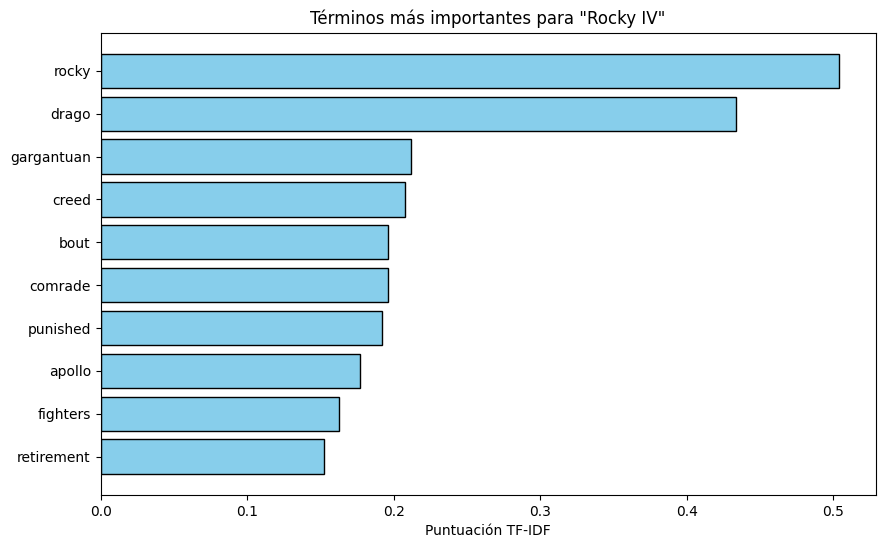

In [10]:
from utils.functions import plot_important_terms_for_movie

plot_important_terms_for_movie('Rocky IV', df_metadata_filtered, tfidf, tfidf_matrix)

Las palabras **"Rocky", "Drago", "Creed" y "Apollo"** son nombres de personajes principales de la saga, lo que confirma que los personajes clave tienen un peso significativo en el análisis TF-IDF. Además, términos como "bout" (combate), "fighters" (luchadores) y "retirement" (retiro) son relevantes, ya que están directamente relacionados con el tema de la película, que es el boxeo. Sin embargo, palabras como "gargantuan" (gigantesco) y "comrade" (camarada) pueden estar contextualizadas dentro de la trama de la película, pero podrían no ser tan representativas del género o del tema principal.

Para mejorar el análisis, se podría agregar palabras clave de contexto cinematográfico. Por ejemplo, incluir nombres de actores principales como **"Sylvester Stallone" y "Dolph Lundgren"** puede proporcionar más contexto a la película. También, añadir el nombre del director, en este caso "Sylvester Stallone", sería útil. Palabras como "1985" pueden ser relevantes para identificar la época de la película, y términos como "drama" y "deportes" pueden ayudar a categorizar mejor la película.

En cuanto al ajuste de pesos en el vectorizador TF-IDF, se puede hacer que no solo considere la frecuencia dentro de la sinopsis, **sino también su relevancia en el contexto cinematográfico**. Esto se puede lograr dando un peso extra a términos que se identifiquen previamente como importantes. Además, agregar campos adicionales en el análisis TF-IDF que incluyan información de actores, directores y género puede garantizar que estos términos se consideren adecuadamente en las recomendaciones.

Finalmente guardo en formato CSV el dataframe trabajado en este notebook ya que se seguirá usando más adelante:

In [11]:
df_metadata_filtered.to_csv(data_dir("processed", "movies_metadata_filtered_2.csv"), index=False)